# YOLOv8 training on custom dataset

Notebook made based on [YOLOv8 Notebook](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov8-object-detection-on-custom-dataset.ipynb) by Roboflow.


## Before start


In [1]:
!nvidia-smi

Sun Jan 14 13:38:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8              13W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Install and import YOLOv8


In [3]:
!pip install ultralytics==8.0.196

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 6.6 MB/s eta 0:00:00


In [4]:
from ultralytics import YOLO

## Install roboflow, download dataset

In [6]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="API_KEY")
project = rf.workspace("roboflow-100").project("animals-ij5d2")
dataset = project.version(2).download("yolov8")

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to animals-2 in yolov8:: 100%|██████████| 2012/2012 [00:00<00:00, 7280.81it/s]


## Custom Training

In [7]:
%cd {HOME}

!yolo task=detect mode=train model=yolov8s.pt data={dataset.location}/data.yaml epochs=1 batch=8

/content
100% 21.5M/21.5M [00:00<00:00, 268MB/s]
New https://pypi.org/project/ultralytics/8.1.1 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/datasets/animals-2/data.yaml, epochs=1, patience=50, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=Fa

## Install and import supervision and numpy

In [8]:
!pip install -q supervision==0.13.0
!pip install numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.3/59.3 kB 1.3 MB/s eta 0:00:00


In [9]:
import supervision as sv
import numpy as np

## Analize trained model using supervision

Load test dataset with supervision

In [10]:
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/test/images",
    annotations_directory_path=f"{dataset.location}/test/labels",
    data_yaml_path=f"{dataset.location}/data.yaml",
)

print('dataset classes:', ds.classes)

dataset classes: ['cat', 'chicken', 'cow', 'dog', 'fox', 'goat', 'horse', 'person', 'racoon', 'skunk']


Create callback function

In [11]:
model = YOLO('/content/runs/detect/train/weights/best.pt')
def callback(image: np.ndarray) -> sv.Detections:
    result = model(image)[0]
    return sv.Detections.from_ultralytics(result)

Calculate mAP per class

In [12]:
mean_average_precision = sv.MeanAveragePrecision.benchmark(
     dataset = ds,
     callback = callback
)
file_path = f"{HOME}/map_per_class.txt"
with open(file_path, "w") as file:
  file.write(f"mAP: {mean_average_precision.map50_95}\n")
  print('mAP:', mean_average_precision.map50_95)
  per_class_map = mean_average_precision.per_class_ap50_95.mean(axis=1)
  for class_name, value in zip(ds.classes, per_class_map):
      print(f"{class_name}: {value:.2f}")
      file.write(f"{class_name}: {value:.2f}\n")


WARNING ⚠️ NMS time limit 0.550s exceeded
0: 416x640 1 goat, 3 skunks, 249.5ms
Speed: 3.9ms preprocess, 249.5ms inference, 870.9ms postprocess per image at shape (1, 3, 416, 640)

0: 544x640 2 chickens, 1 cow, 114.8ms
Speed: 7.2ms preprocess, 114.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

0: 640x640 1 cow, 1 goat, 17.2ms
Speed: 5.2ms preprocess, 17.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 (no detections), 122.1ms
Speed: 2.2ms preprocess, 122.1ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 cow, 148.7ms
Speed: 3.6ms preprocess, 148.7ms inference, 8.4ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 cow, 1 dog, 1 goat, 6 racoons, 32.3ms
Speed: 5.0ms preprocess, 32.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 1 cow, 1 goat, 232.6ms
Speed: 2.3ms preprocess, 232.6ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

0: 448x64

mAP: 0.28843083665634267
cat: 0.00
chicken: 0.31
cow: 0.34
dog: 0.35
fox: 0.46
goat: 0.14
horse: 0.47
person: 0.44
racoon: 0.18
skunk: 0.18


Calculate confusion matrix


0: 416x640 1 goat, 3 skunks, 35.2ms
Speed: 2.9ms preprocess, 35.2ms inference, 2.2ms postprocess per image at shape (1, 3, 416, 640)

0: 544x640 2 chickens, 1 cow, 55.4ms
Speed: 2.3ms preprocess, 55.4ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

0: 640x640 1 cow, 1 goat, 39.4ms
Speed: 2.6ms preprocess, 39.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 (no detections), 40.8ms
Speed: 2.0ms preprocess, 40.8ms inference, 0.9ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 cow, 38.6ms
Speed: 2.1ms preprocess, 38.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

0: 640x640 1 cow, 1 dog, 1 goat, 6 racoons, 17.4ms
Speed: 2.6ms preprocess, 17.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 512x640 1 cow, 1 goat, 14.3ms
Speed: 2.1ms preprocess, 14.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

0: 448x640 3 chickens, 1 fox, 20.6ms
Speed: 1.9ms preprocess, 2

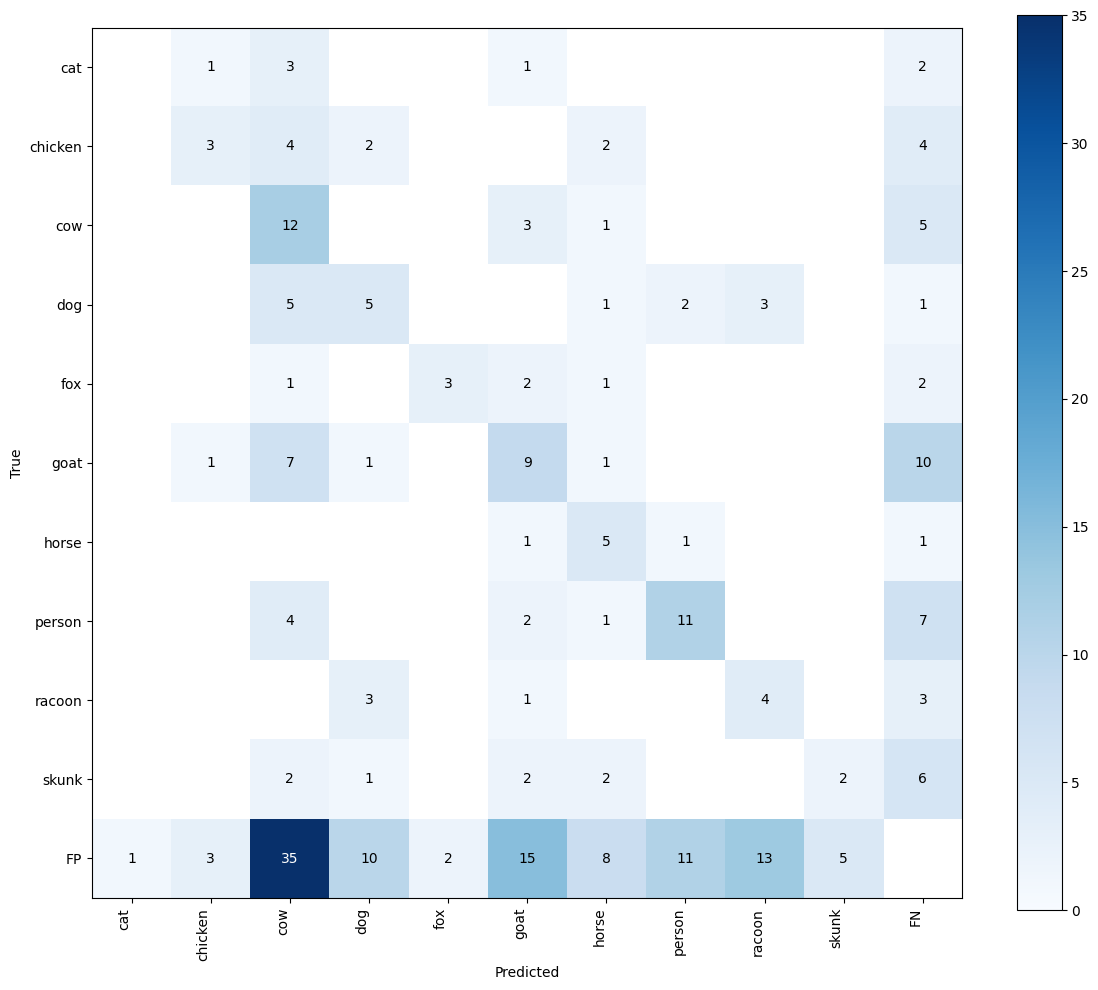

In [15]:
confusion_matrix = sv.ConfusionMatrix.benchmark(
     dataset = ds,
     callback = callback
)
confusion_matrix_plot = confusion_matrix.plot()
confusion_matrix_plot.savefig(f"{HOME}/confusion_matrix.png")